In [1]:
# Set up environment variables
# IMPORTANT: Set these in your .env file or system environment variables before running
# Copy .env.example to .env and fill in your actual API keys
%env OPENROUTER_API_KEY=your_openrouter_api_key_here

env: OPENROUTER_API_KEY=your_openrouter_api_key_here


In [2]:
from datasets import load_dataset, Dataset
import pandas as pd

# Load the Lex Fridman podcast dataset
lex_dataset = load_dataset("RamAnanth1/lex-fridman-podcasts", split="train")

# Convert to pandas DataFrame for easier manipulation
lex_df = lex_dataset.to_pandas()

# The dataset only has "title" and "text" fields, so no grouping is needed
# If there is an "id" or similar, we can keep it, but otherwise just keep title and text
lex_video_df = lex_df[["title", "captions"]].copy()
lex_video_df = lex_video_df.rename(columns={"captions": "text"})
lex_video_df["video_id"] = lex_video_df.index.astype(str)


# Convert back to HuggingFace Dataset
video_dataset = Dataset.from_pandas(lex_video_df, preserve_index=False)
video_dataset


Dataset({
    features: ['title', 'text', 'video_id'],
    num_rows: 319
})

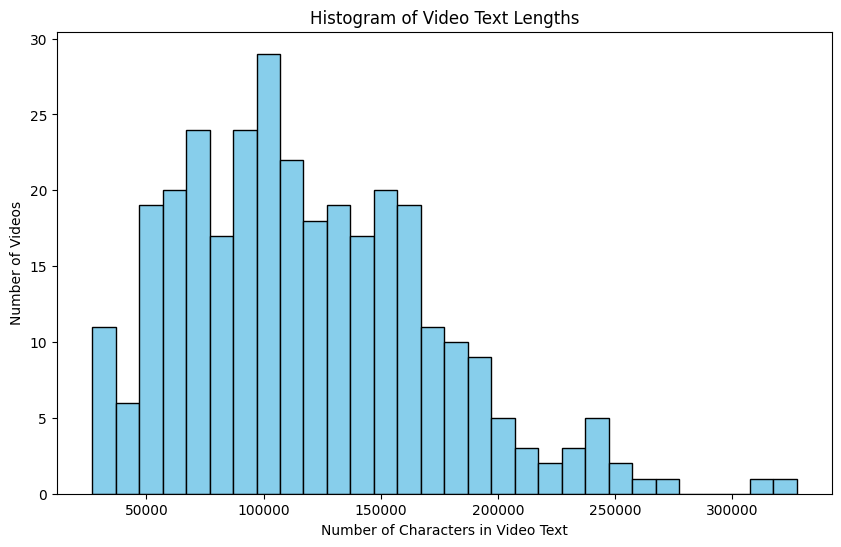

In [3]:
import matplotlib.pyplot as plt

# Compute lengths of each video's text
video_lengths = [len(video['text']) for video in video_dataset]

plt.figure(figsize=(10, 6))
plt.hist(video_lengths, bins=30, color='skyblue', edgecolor='black')
plt.title("Histogram of Video Text Lengths")
plt.xlabel("Number of Characters in Video Text")
plt.ylabel("Number of Videos")
plt.show()


In [4]:
# Only keep rows in video_dataset with text length < 200000
video_dataset = video_dataset.filter(lambda x: len(x['text']) < 200000)
print(f'Length of video_dataset: {len(video_dataset)}')

Filter:   0%|          | 0/319 [00:00<?, ? examples/s]

Length of video_dataset: 297


In [5]:
model_name = "openai/gpt-4.1-mini"

In [6]:
from openai import OpenAI
from os import getenv

client = OpenAI(
    api_key=getenv("OPENROUTER_API_KEY"),
    base_url="https://openrouter.ai/api/v1"
)
def summarize_text(text, model_name):
    response = client.chat.completions.create(
        model=model_name,
        messages=[
            {"role": "system", "content": "You are a helpful assistant that summarizes text in full paragraphs using full sentences without missing any important information."},
            {"role": "user", "content": f"Summarize the following text in as many paragraphs as you need. Capture as much of the text as possible in the summary:\n\n{text}\n\nSummary:"}
        ],
        temperature=1,
    )
    return response

In [7]:
from tqdm import tqdm
all_summaries = []

print(f'Length of all_summaries: {len(all_summaries)}')

Length of all_summaries: 0


In [8]:
# Example usage with video_dataset:
summary_response = summarize_text(video_dataset[0]['text'], model_name=model_name)
summary = summary_response.choices[0].message.content
print("Summary:", summary)

for key, value in summary_response.usage.__dict__.items():
    print(key, value)


Summary: Max Tegmark, a physicist and professor at MIT involved in the artificial general intelligence (AGI) course 6S099, shares his views on various deep topics related to the universe, intelligent life, consciousness, and the future of AI. With a career exploring the mysteries of the cosmological universe, Tegmark has also extensively studied the potential benefits and existential risks posed by artificial intelligence. He emphasizes his role as a co-founder of the Future of Life Institute and as the author of well-regarded books such as "Our Mathematical Universe" and "Life 3.0," which bridge philosophy and engineering to explore AI’s implications for human goals and existence.

Tegmark expresses a minority but carefully reasoned view on the existence of intelligent extraterrestrial life. He argues that despite the vast number of galaxies and Earth-like planets, the lack of evidence of advanced civilizations visiting Earth and the vast distances involved suggest that technologicall

In [9]:
print(f'Using model {model_name}')
for idx, video in tqdm(enumerate(video_dataset), desc="Summarizing videos", total=len(video_dataset)):
    if idx < len(all_summaries):
        continue
    try:
        summary_response = summarize_text(video['text'], model_name=model_name)
        summary = summary_response.choices[0].message.content
        all_summaries.append(dict(
                video_id=video['video_id'], title=video['title'],
                summary=summary, total_tokens=summary_response.usage.total_tokens, 
                prompt_tokens=summary_response.usage.prompt_tokens, completion_tokens=summary_response.usage.completion_tokens,
                ))
    except Exception as e:
        print(f"Error summarizing video {video['video_id']}: {e}")
        continue


Using model openai/gpt-4.1-mini


Summarizing videos:  28%|██▊       | 84/297 [28:55<1:23:12, 23.44s/it]

Error summarizing video 83: 'NoneType' object has no attribute 'total_tokens'


Summarizing videos: 100%|██████████| 297/297 [1:45:48<00:00, 21.37s/it]  


In [10]:
# Convert all_summaries to a pandas DataFrame
import pandas as pd
df = pd.DataFrame(all_summaries)
df.head()


,video_id,title,summary,total_tokens,prompt_tokens,completion_tokens
0,0,Max Tegmark: Life 3.0 | Lex Fridman Podcast #1,"Max Tegmark, a physicist and professor at MIT,...",16478,15442,1036
1,1,Christof Koch: Consciousness | Lex Fridman Pod...,"Christoph Koch, a leading figure in neurobiolo...",13392,12195,1197
2,2,Steven Pinker: AI in the Age of Reason | Lex F...,The discussion begins with an exploration of t...,7699,6934,765
3,3,Yoshua Bengio: Deep Learning | Lex Fridman Pod...,The most mysterious and captivating difference...,7889,6894,995
4,4,Vladimir Vapnik: Statistical Learning | Lex Fr...,"The conversation with Vladimir Vapnik, a pivot...",8414,7553,861


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import re

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Load a sentence transformer model from HuggingFace
EMBEDDING_MODEL = "all-MiniLM-L6-v2"
model = SentenceTransformer(EMBEDDING_MODEL, trust_remote_code=True)

In [12]:
all_similarities = []
verbose = False
# Define the specific regex pattern for timestamps
timestamp_pattern = r'(\[\d{2}:\d{2}:\d{2} - \d{2}:\d{2}:\d{2}\])'
# define regex to split by sentence
sentence_pattern = r'(?<=[.!?])\s+'

# Iterate over each video in the video_dataset
for idx, video in tqdm(enumerate(video_dataset), total=len(video_dataset), desc="Calculating similarities"):
    video_id = video['video_id']
    video_title = video['title']
    original_text = video['text']
    # Find the summary for this video_id in df
    summary_row = df[df['video_id'] == video_id]
    if summary_row.empty:
        print(f"Summary for video_id {video_id} not found.")
        continue
    summary = summary_row.iloc[0]['summary']

    # Chunk into sentences using the specific timestamp pattern
    chunks_A = re.split(sentence_pattern, original_text)
    JOIN_CHUNK_A_SIZE = 10  # join sentences to make chunks_A larger
    chunks_A = [' '.join(chunks_A[i:i+JOIN_CHUNK_A_SIZE]) for i in range(0, len(chunks_A), JOIN_CHUNK_A_SIZE)]
    if verbose:
        print(f'Original words: {len(original_text.split(' '))}. Original chunk size: {len(chunks_A)}')
    chunks_B = re.split(sentence_pattern, summary)  # output of prompt is a summary
    if verbose:
        print(f'Summary words: {len(summary.split(' '))}. Summary chunk size: {len(chunks_B)}')
    try:
        # Get embeddings
        A_embeds = model.encode(chunks_A, convert_to_numpy=True)
        B_embeds = model.encode(chunks_B, convert_to_numpy=True)
        # For each sentence in chunks_B, get cosine similarity to all sentences in chunks_A
        similarities = cosine_similarity(B_embeds, A_embeds)
        all_similarities.append(similarities)
    except Exception as e:
        print(f"Error embedding video {video_id}: {e}")
        continue


Calculating similarities:  28%|██▊       | 83/297 [01:00<02:06,  1.70it/s]

Summary for video_id 83 not found.


Calculating similarities: 100%|██████████| 297/297 [05:15<00:00,  1.06s/it]


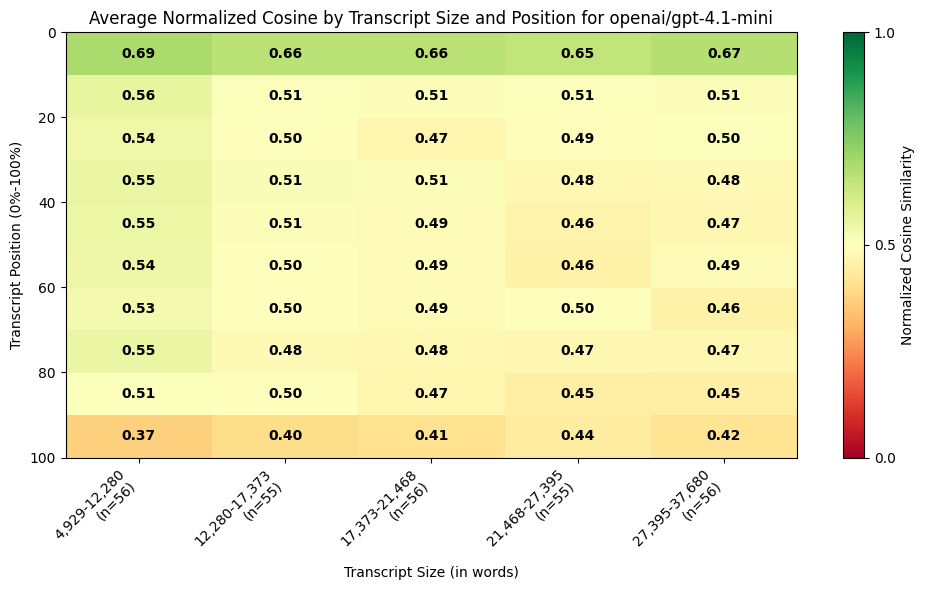

In [15]:
# Bucket videos by their original text length and average similarities within each bucket
import math

# Number of buckets (default 5)
n_buckets = 5

# Get original text length for each video (from df, which has 'text' and 'video_id')
# Build a mapping from video_id to prompt token count (original text length)
video_id_to_prompt_tokens = {v['video_id']: v['text'].count(' ') + 1 for v in video_dataset if int(v['video_id']) in df['video_id']}

# Build a list of (video, text_length, similarity) only for videos that have both text_length and similarity
valid_video_info = []
for i, video in enumerate(video_dataset):
    video_id = video['video_id']
    prompt_tokens = video_id_to_prompt_tokens.get(video_id, None)
    # Only include if prompt_tokens is not None and similarity exists for this index
    if prompt_tokens is not None and i < len(all_similarities):
        similarity = all_similarities[i]
        valid_video_info.append((video, prompt_tokens, similarity))

if not valid_video_info:
    print("No valid videos with both prompt token counts and similarities.")
    # Optionally, exit or skip the rest of the code
else:
    valid_video_dataset = [v[0] for v in valid_video_info]
    valid_prompt_token_counts = [v[1] for v in valid_video_info]
    valid_similarities = [v[2] for v in valid_video_info]

    # Sort by prompt token count for quantile bucketing
    sorted_indices = np.argsort(valid_prompt_token_counts)

    sorted_prompt_tokens = np.array(valid_prompt_token_counts)[sorted_indices]
    sorted_video_dataset = [valid_video_dataset[i] for i in sorted_indices]
    sorted_similarities = [valid_similarities[i] for i in sorted_indices]

    # Compute bucket edges for equal-sized buckets (quantiles)
    total = len(sorted_prompt_tokens)
    bucket_indices = []
    bucket_edges = []
    for b in range(n_buckets):
        start_idx = int(round(b * total / n_buckets))
        end_idx = int(round((b + 1) * total / n_buckets))
        bucket_indices.append(list(range(start_idx, end_idx)))
        if end_idx > 0:
            bucket_edges.append(sorted_prompt_tokens[start_idx])
    # Add the last edge
    bucket_edges.append(sorted_prompt_tokens[-1])

    # For each video, compute normalized similarity vector (as before)
    norm_similarities_list = []
    for similarities in sorted_similarities:
        avg_similarities = np.max(similarities, axis=0)  # shape: (len(chunks_A),)
        norm_similarities_list.append(avg_similarities)

    # To average, we need to interpolate all similarity vectors to the same length (e.g., 100 points)
    interp_len = 10
    norm_similarities_interp = []
    for norm_sim in norm_similarities_list:
        x_old = np.linspace(0, 1, len(norm_sim))
        x_new = np.linspace(0, 1, interp_len)
        norm_sim_interp = np.interp(x_new, x_old, norm_sim)
        norm_similarities_interp.append(norm_sim_interp)

    # Now, for each bucket, average the interpolated similarities
    bucket_avg_similarities = []
    bucket_counts = []
    for b in range(n_buckets):
        idxs = bucket_indices[b]
        if idxs:
            arrs = [norm_similarities_interp[i] for i in idxs]
            avg_arr = np.mean(arrs, axis=0)
            bucket_avg_similarities.append(avg_arr)
            bucket_counts.append(len(idxs))
        else:
            bucket_avg_similarities.append(np.full(interp_len, np.nan))
            bucket_counts.append(0)

    # Plot: each column is a bucket, y-axis is normalized sentence index (0-100%), color is avg similarity
    fig, ax = plt.subplots(figsize=(2 * n_buckets, 6))
    # Stack columns horizontally: shape (interp_len, n_buckets)
    heatmap_data = np.stack(bucket_avg_similarities, axis=1)  # shape: (interp_len, n_buckets)

    # Set up y-axis scaling (0% at top, 100% at bottom)
    y_start, y_end = 100, 0
    extent = [0, n_buckets, y_start, y_end]

    im = ax.imshow(heatmap_data, aspect='auto', cmap='RdYlGn', extent=extent, vmin=0, vmax=1)
    cbar = plt.colorbar(im, ax=ax, label='Normalized Cosine Similarity', ticks=[0, 0.5, 1])
    ax.set_xticks(np.arange(n_buckets) + 0.5)
    # Label buckets by token range
    bucket_labels = []
    for b in range(n_buckets):
        left = int(bucket_edges[b])
        right = int(bucket_edges[b + 1])
        bucket_labels.append(f"{left:,}-{right:,}\n(n={bucket_counts[b]:,})")
    ax.set_xticklabels(bucket_labels, rotation=45, ha='right')
    ax.set_xlabel('Transcript Size (in words)')
    ax.set_ylabel('Transcript Position (0%-100%)')
    ax.set_title(f'Average Normalized Cosine by Transcript Size and Position for {model_name}')
    plt.ylim(y_start, y_end)
    plt.xlim(0, n_buckets)

    # --- Add numbers in each box for color blind accessibility ---
    # We'll annotate each cell with its value, formatted to 2 decimals
    for i in range(interp_len):
        for j in range(n_buckets):
            
            value = heatmap_data[i, j]
            if not np.isnan(value):
                # Calculate the position in data coordinates
                # x: bucket index + 0.5 (center of bucket)
                # y: normalized sentence index (from y_start to y_end, so invert i)
                x = j + 0.5
                y =  (i + 0.5) * (y_start - y_end) / interp_len
                ax.text(
                    x, y, f"{value:.2f}",
                    ha='center', va='center',
                    color='black',
                    fontsize=10, fontweight='bold'
                )

    plt.tight_layout()
    plt.savefig(f"avg_normalized_cosine_similarity_by_prompt_token_bucket_{model_name.replace('/', '_')}_equal_samples.png", dpi=300)
    plt.show()


Shape of heatmap_data for openai/gpt-4.1-mini: (10, 5)
Data type: float64
Min value: 0.3684184556560857
Max value: 0.6892336894358907
Mean value: 0.5054158536689127
Median value: 0.49833240140267077
Std deviation: 0.06538438686644675
Number of NaNs: 0


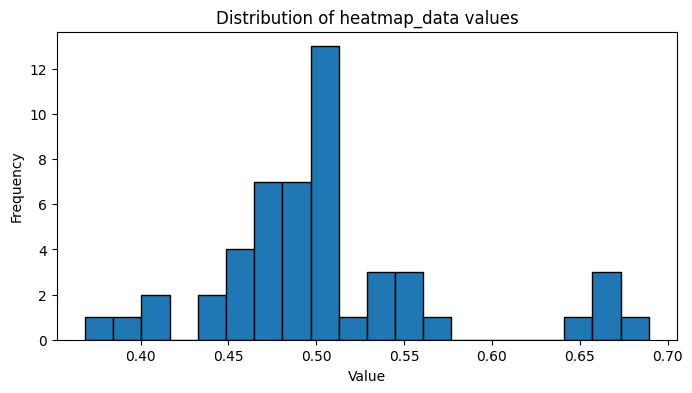

Rows with all NaNs: []
Columns with all NaNs: []


In [17]:
# Exploratory Data Analysis (EDA) of heatmap_data

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# Basic info
print(f"Shape of heatmap_data for {model_name}:", heatmap_data.shape)
print("Data type:", heatmap_data.dtype)

# Summary statistics
print("Min value:", np.nanmin(heatmap_data))
print("Max value:", np.nanmax(heatmap_data))
print("Mean value:", np.nanmean(heatmap_data))
print("Median value:", np.nanmedian(heatmap_data))
print("Std deviation:", np.nanstd(heatmap_data))
print("Number of NaNs:", np.isnan(heatmap_data).sum())

# Distribution of values (flattened, ignoring NaNs)
flat_vals = heatmap_data.flatten()
flat_vals = flat_vals[~np.isnan(flat_vals)]
plt.figure(figsize=(8,4))
plt.hist(flat_vals, bins=20, edgecolor='black')
plt.title("Distribution of heatmap_data values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()


# Check for any rows or columns with all NaNs
nan_rows = np.where(np.all(np.isnan(heatmap_data), axis=1))[0]
nan_cols = np.where(np.all(np.isnan(heatmap_data), axis=0))[0]
print("Rows with all NaNs:", nan_rows)
print("Columns with all NaNs:", nan_cols)